In [62]:
# import libraries
import os
import PIL
from PIL import Image
import numpy as np
from numpy import asarray
from numpy import clip
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from mlens.ensemble import SuperLearner
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from scipy import stats
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor

In [583]:
def processImage(file, grayscale = True, basewidth = 280):
    
    img = Image.open(file).convert('L')
        
    # resize image
    wpercent = (basewidth / float(img.size[0]))
    hsize = int((float(img.size[1]) * float(wpercent)))
    img = img.resize((basewidth, hsize), PIL.Image.ANTIALIAS)
    
    return img

def LRWarp(img, prop_row, prop_col, iterations, verbose = False):
    
    # convert image to array
    img_array = asarray(img)
    pred_img = np.empty(((img_array.shape[0], img_array.shape[1], iterations)))
            
    for i in range(iterations):
        if verbose == True:
            print("Processing Iteration #", i + 1)
        for col in range(img_array.shape[1]):
            X = np.delete(img_array, col, axis=1)
            y = img_array[:, col]
            row_sample = np.random.choice(range(X.shape[0]), size=round(prop_row*X.shape[0]), replace = False)
            col_sample = np.random.choice(range(X.shape[1]), size=round(prop_col*X.shape[1]), replace = False)
            X_rc_samp = X[row_sample, :]
            X_rc_samp = X_rc_samp[:, col_sample]
            y_r_samp = y[row_sample]
            reg = LinearRegression().fit(X_rc_samp, y_r_samp)
            X_c_samp = X[:, col_sample]
            pred_img[:, col, i] = reg.predict(X_c_samp)
            
    pred_img_flat = pred_img.mean(axis = 2)     
    pred_img_flat = np.round(pred_img_flat)
    pred_img_flat = np.clip(pred_img_flat, 0, 255)
    result = Image.fromarray(np.uint8(pred_img_flat))
    
    return result

def LRWarp2(img1, img2, prop_row, prop_col, iterations, verbose = False):
    
    # convert image to array
    img1_array = asarray(img1)
    img2_array = asarray(img2)
    pred_img = np.empty(((img1_array.shape[0], img1_array.shape[1], iterations)))
            
    for i in range(iterations):
        if verbose == True:
            print("Processing Iteration #", i + 1)
        for col in range(img1_array.shape[1]):
            X1 = np.delete(img1_array, col, axis=1)
            X2 = np.delete(img2_array, col, axis=1)
            y1 = img1_array[:, col]
            row_sample = np.random.choice(range(X1.shape[0]), size=round(prop_row*X1.shape[0]), replace = False)
            col_sample = np.random.choice(range(X1.shape[1]), size=round(prop_col*X1.shape[1]), replace = False)
            X1_rc_samp = X1[row_sample, :]
            X1_rc_samp = X1_rc_samp[:, col_sample]
            y1_r_samp = y1[row_sample]
            reg = LinearRegression().fit(X1_rc_samp, y1_r_samp)
            X2_c_samp = X2[:, col_sample]
            pred_img[:, col, i] = reg.predict(X2_c_samp)
            
    pred_img_flat = pred_img.mean(axis = 2)     
    pred_img_flat = np.round(pred_img_flat)
    pred_img_flat = np.clip(pred_img_flat, 0, 255)
    result = Image.fromarray(np.uint8(pred_img_flat))
    
    return result

def getIndexData(img, poly_degree):
    
    img_t = asarray(img)
    X = np.empty((img_t.shape[0]*img_t.shape[1], 2))
    y = np.empty(img_t.shape[0]*img_t.shape[1])
    i = 0
    for r in range(img_t.shape[0]):
        for c in range(img_t.shape[1]):
            X[i, 0] = r
            X[i, 1] = c
            y[i] = img_t[r, c]
            i = i + 1
    poly = PolynomialFeatures(poly_degree)
    X = poly.fit_transform(X)
    X = np.delete(X, 0, axis = 1)
    X = stats.zscore(X, axis = 0)

    return X, y

def convertIndexToImage(og_img_shape, pred_y):
    
    pred_img = np.empty(og_img_shape)
    
    i = 0
    for r in range(og_img_shape[0]):
        for c in range(og_img_shape[1]):
            pred_img[r, c] = pred_y[i]
            i = i + 1
            
    return pred_img

def modelIndexWarp(X, y, prop_row, mod, nbs, og_image_shape):
    if mod == "rf":
        model = RandomForestRegressor()
    if mod == "xgb":
        model = XGBRegressor(objective='reg:squarederror')
    if mod == "knn":
        model = KNeighborsRegressor(n_neighbors = nbs)
    if mod == "et":
        model = ExtraTreesRegressor()
        
    row_sample = np.random.choice(range(X.shape[0]), size=round(prop_row*X.shape[0]), replace = False)
    X_sample = X[row_sample, :]
    y_sample = y[row_sample]
    reg = model.fit(X_sample, y_sample)
    pred_y = reg.predict(X)
    pred_y = np.round(pred_y)
    pred_y = np.clip(pred_y, 0, 255)
    pred_img = convertIndexToImage(og_image_shape, pred_y)
    result = Image.fromarray(np.uint8(pred_img))
    return result

def permutationWarp(img, iterations, max_block_prop):

    img_array = asarray(img)
    pred_img = np.empty(((img_array.shape[0], img_array.shape[1], iterations)))

    for i in range(iterations):
        pred_img_single = np.empty(img_array.shape)

        d = np.random.binomial(1, 0.5)
        if d == 1:
            img_array = img_array.T
            pred_img_single = pred_img_single.T

        block_size = np.random.choice(range(1, round(max_block_prop*img_array.shape[0])))
        s = 0
        while s + block_size < img_array.shape[0]:
            p_order = np.random.choice(range(s, s+block_size), size = block_size, replace = False)
            pred_img_single[s:s+block_size, :] = img_array[p_order, :]
            s = s + block_size

        p_order = np.random.choice(range(s, img_array.shape[0]), size = (img_array.shape[0] - s), replace = False)
        pred_img_single[s:img_array.shape[0], :] = img_array[p_order, :]

        if d == 1:
            img_array = img_array.T
            pred_img_single = pred_img_single.T

        pred_img[:, :, i] = pred_img_single

    pred_img = pred_img.mean(axis = 2) 
    result = Image.fromarray(np.uint8(pred_img))
    
    return result

In [584]:
# import photo
os.chdir('/Users/chrisrowe/Documents/personal_projects/photo_warp/photos/')

# open and process images
img_cr = processImage('cr.jpg')
img_stump = processImage('stump.jpg')

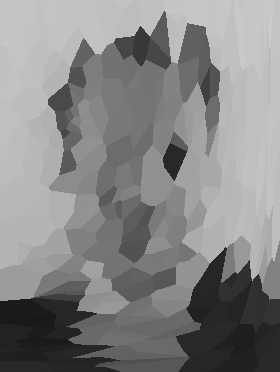

In [628]:
X, y = getIndexData(img_cr, poly_degree = 30)
knn = modelIndexWarp(X, y, prop_row = 0.003,
              mod = 'knn', nbs = 1, og_image_shape = asarray(img_cr).shape)
knn

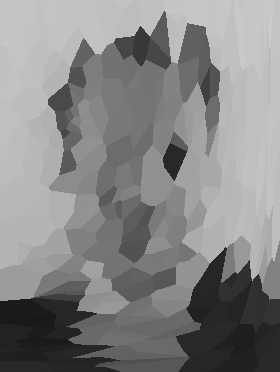

In [637]:
#new1 = knn
#new2 = knn
#new3 = knn
new4
#knn_final1 = knn
#xgb_final1 = xgb
#xgb_final2 = xgb
#rf_final1 = rf
#rf_final2 = rf
#et_final1 = et
#et_final2 = et
#knn_final2 = knn

In [639]:
panel_n = new1
panel_n = np.hstack((panel_n, new2))
panel_n = np.hstack((panel_n, new3))
panel_n = np.hstack((panel_n, new4))
final_panel = np.vstack((final_panel, panel_n))

In [493]:
panel = knn_final1
panel = np.hstack((panel, knn_final2))
panel = np.hstack((panel, xgb_final1))
panel = np.hstack((panel, xgb_final2))
panel_b = rf_final1
panel_b = np.hstack((panel_b, rf_final2))
panel_b = np.hstack((panel_b, et_final1))
panel_b = np.hstack((panel_b, et_final2))

final_panel = np.vstack((panel, panel_b))



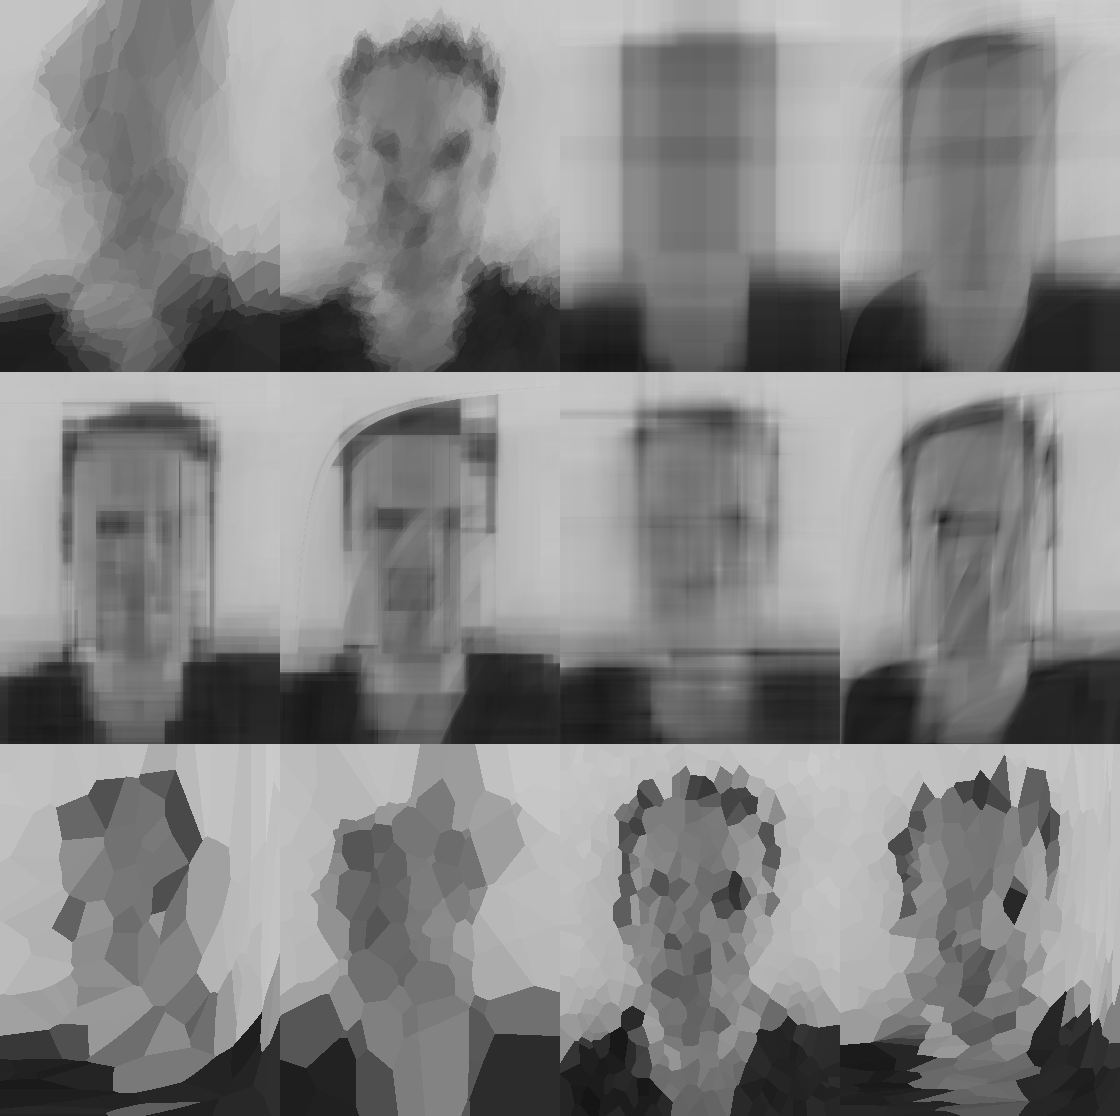

In [640]:
final_panel = Image.fromarray(np.uint8(final_panel))
final_panel

In [641]:
final_panel.save('model_index_panel_12.jpg')

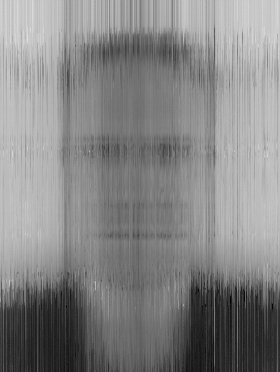

In [438]:
LRWarp(img_cr, prop_row = 0.2, prop_col = 0.01, 
       iterations = 4, verbose = False)

In [154]:
def createPanel(*imgs):
    
    num_imgs = len(imgs)
    pixel_width = shape[0]*imgs[0].shape[1]
    wide_panel = imgs[0]
    for i in range(1, num_imgs):
        wide_panel = np.hstack((wide_panel, imgs[i]))
    
    for i in shape[1]:
        panel = np.vstack((wide_panel[:, pixel_width*(i):pixel_width*(i+1)], 
                           wide_panel[:, pixel_width*(i+1) ]))
    
    return panel

In [156]:
createPanel(test1, test2, test3).shape

(372, 840)

In [477]:
X, y = getIndexData(img_cr, poly_degree = 3)

In [484]:
model = Sequential()
model.add(Dense(512, input_shape=(X.shape[1],), activation='relu'))
model.add(Dense(256, activation='sigmoid'))
model.add(Dense(128, activation='linear'))
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(1, activation='linear'))

In [485]:
model.compile(loss='mse', 
              optimizer='adam', 
              metrics=['mse'])

In [486]:
prop_row = 0.5
row_sample = np.random.choice(range(X.shape[0]), size=round(prop_row*X.shape[0]), replace = False)
X_sample = X[row_sample, :]
y_sample = y[row_sample]

In [487]:
model.fit(X_sample, y_sample,
  batch_size=32,
  epochs=5,
  verbose=1,
  validation_split=0.1,
  shuffle=True)

Train on 46872 samples, validate on 5208 samples
Epoch 1/5
46872/46872 [==============================] - 1s 25us/sample - loss: 17120.2486 - mse: 17120.2441 - val_loss: 15445.6704 - val_mse: 15445.6680
Epoch 2/5
46872/46872 [==============================] - 1s 19us/sample - loss: 13557.7699 - mse: 13557.7734 - val_loss: 12244.6968 - val_mse: 12244.6963
Epoch 3/5
46872/46872 [==============================] - 1s 19us/sample - loss: 10717.6693 - mse: 10717.6650 - val_loss: 9679.9532 - val_mse: 9679.9521
Epoch 4/5
46872/46872 [==============================] - 1s 19us/sample - loss: 8464.6973 - mse: 8464.6953 - val_loss: 7661.2559 - val_mse: 7661.2559
Epoch 5/5
46872/46872 [==============================] - 1s 19us/sample - loss: 6713.5061 - mse: 6713.5059 - val_loss: 6108.2704 - val_mse: 6108.2715


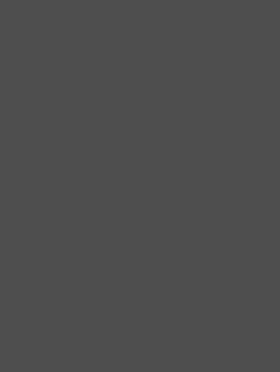

In [488]:
pred_y = model.predict(X)
pred_y = np.round(pred_y)
pred_y = np.clip(pred_y, 0, 255)

i = 0
pred_img = np.empty(asarray(img_cr).shape)
for r in range(asarray(img_cr).shape[0]):
    for c in range(asarray(img_cr).shape[1]):
        pred_img[r, c] = pred_y[i]
        i = i + 1


result = Image.fromarray(np.uint8(pred_img))
result

In [465]:
result_nn = result

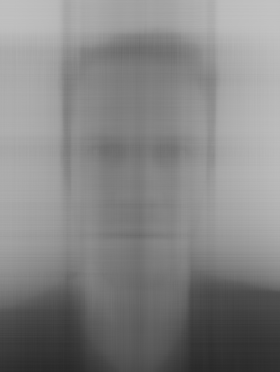

In [333]:
permutationWarp(img_cr, 1000, 1)

In [499]:
# import photo
os.chdir('/Users/chrisrowe/Documents/personal_projects/photo_warp/photos/')

# open and process images
img_house = processImage('house.jpg')


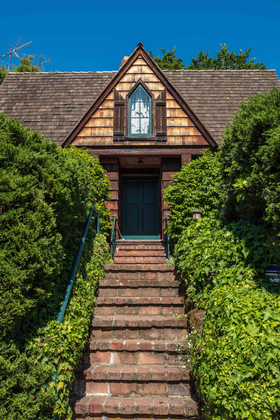

In [500]:
img_house

In [501]:
img_house = asarray(img_house)

(420, 280, 3)

In [574]:
pd = 4
pr = 0.01

X, y = getIndexData(img_house[:, :, 0], poly_degree = pd)
knn0 = modelIndexWarp(X, y, prop_row = pr,
              mod = 'knn', og_image_shape = asarray(img_house[:, :, 0]).shape)
X, y = getIndexData(img_house[:, :, 1], poly_degree = pd)
knn1 = modelIndexWarp(X, y, prop_row = pr,
              mod = 'knn', og_image_shape = asarray(img_house[:, :, 1]).shape)
X, y = getIndexData(img_house[:, :, 2], poly_degree = pd)
knn2 = modelIndexWarp(X, y, prop_row = pr,
              mod = 'knn', og_image_shape = asarray(img_house[:, :, 2]).shape)
color_pick = np.stack((knn0, knn1, knn2), axis=2)

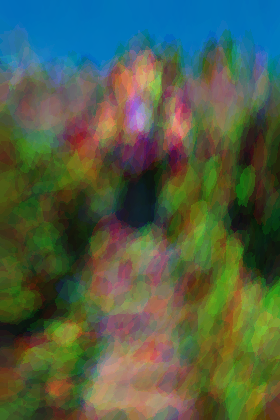

In [575]:
result = Image.fromarray(np.uint8(color_pick))
result